This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Pattern matching

Crystal orientations can be determined from experimental EBSD patterns by matching them to simulated patterns of known phases and orientations, see e.g. <cite data-cite="chen2015dictionary">Chen et al. (2015)</cite>, <cite data-cite="nolze2016pattern">Nolze et al. (2016)</cite>, <cite data-cite="foden2019indexing">Foden et al. (2019)</cite>.

In this tutorial, we will perform *dictionary indexing* (DI) using a small Ni EBSD data set and a dynamically simulated Ni master pattern from EMsoft, both of low resolution and found in the [kikuchipy.data](../reference/generated/kikuchipy.data.rst) module.
The pattern dictionary is generated from a uniform grid of orientations with a fixed projection center (PC) followng <cite data-cite="singh2016orientation">Singh and De Graef (2016)</cite>.
The true orientation is likely to fall in between grid points, which means there is always a lower angular accuracy associated with DI.
We can improve upon each solution by letting the orientation deviate from the grid points.
We do this by maximizing the similarity between experimental and simulated patterns using numerical optimization algorithms.
This is here called *orientation refinement*.
We could instead keep the orientations fixed and let the PC parameters deviate from their fixed values used in the dictionary, here called *projection center refinement*.
Finally, we can also refine both at the same time, here called *orientation and projection center refinement*.
The need for orientation or orientation and PC refinement is discussed by e.g. <cite data-cite="singh2017application">Singh et al. (2017)</cite>, <cite data-cite="winkelmann2020refined">Winkelmann et al. (2020)</cite>, and <cite data-cite="pang2020global">Pang et al. (2020)</cite>.

The term *pattern matching* is here used for the combined approach of DI followed by refinement.

Before we can generate a dictionary of simulated patterns, we need a master pattern containing all possible scattering vectors for a candidate phase.
This can be simulated using EMsoft (<cite data-cite="callahan2013dynamical">Callahan and De Graef (2013)</cite> and <cite data-cite="jackson2014h5ebsd">Jackson et al. (2014)</cite>) and then read into kikuchipy.

First, we import libraries

In [1]:
# Exchange inline for notebook or qt5 (from pyqt) for interactive plotting
%matplotlib inline

import tempfile

import matplotlib.pyplot as plt
import numpy as np

import hyperspy.api as hs
import kikuchipy as kp
from orix import sampling, plot, io
from orix.vector import Vector3d


plt.rcParams.update({"figure.facecolor": "w", "font.size": 15})

Load the small experimental nickel test data

In [2]:
# Use kp.load("data.h5") to load your own data
s = kp.data.nickel_ebsd_large(allow_download=True)  # External download
s

<EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

To obtain a good match, we must increase the signal-to-noise ratio.
In this pattern matching analysis, the Kikuchi bands are considered the signal, and the angle-dependent backscatter intensity, along with unwanted detector effects, are considered to be noise.
See the [pattern processing tutorial](pattern_processing.rst) for further details.

In [3]:
s.remove_static_background()
s.remove_dynamic_background()

[########################################] | 100% Completed | 202.16 ms
[########################################] | 100% Completed | 606.26 ms


<div class="alert alert-info">

Note

DI is computationally intensive and takes in general a long time to run due to all the pattern comparisons being done.
To maintain an acceptable memory usage and be done within reasonable time, it is recommended to write processed patterns to an HDF5 file for quick reading during DI.

</div>

In [4]:
# s.save("pattern_static_dynamic.h5")

## Dictionary indexing

### Load a master pattern

Next, we load a dynamically simulated Nickel master pattern generated with EMsoft, in the northern hemisphere projection of the square Lambert projection for an accelerating voltage of 20 keV

In [5]:
energy = 20
mp = kp.data.nickel_ebsd_master_pattern_small(
    projection="lambert", energy=energy
)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

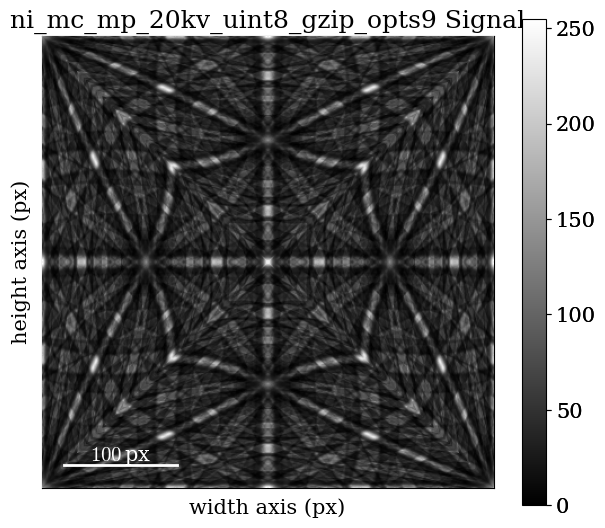

In [6]:
mp.plot()

The Nickel phase information, specifically the crystal symmetry, asymmetric atom positions, and crystal lattice, is conveniently stored in an [orix.crystal_map.Phase](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.Phase.html)

In [7]:
ni = mp.phase

print(ni)
print(ni.structure)

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
lattice=Lattice(a=0.35236, b=0.35236, c=0.35236, alpha=90, beta=90, gamma=90)
28   0.000000 0.000000 0.000000 1.0000


### Sample orientation space

If we don't know anything about the possible crystal (unit cell) orientations in our sample, the safest thing to do is to generate a dictionary of orientations uniformly distributed in a candidate phase's orientation space.
To achieve this, we sample the Rodrigues Fundamental Zone of the proper point group *432* using cubochoric sampling <cite data-cite="singh2016orientation">Singh and De Graef (2016)</cite> available in [orix.sampling.get_sample_fundamental()](https://orix.readthedocs.io/en/stable/reference/generated/orix.sampling.get_sample_fundamental.html).
We can choose the average disorientation between orientations, the "resolution", of this sampling.
Here, we will use a rather low resolution of 3$^{\circ}$.

In [8]:
rot = sampling.get_sample_fundamental(
    method="cubochoric", resolution=3, point_group=ni.point_group
)
rot

Rotation (30443,)
[[ 0.8562 -0.3474 -0.3474 -0.1595]
 [ 0.8562 -0.3511 -0.3511 -0.1425]
 [ 0.8562 -0.3544 -0.3544 -0.1252]
 ...
 [ 0.8562  0.3544  0.3544  0.1252]
 [ 0.8562  0.3511  0.3511  0.1425]
 [ 0.8562  0.3474  0.3474  0.1595]]

This sampling resulted in about 30 000 crystal orientations.
See the [orix documentation on orientation sampling](https://orix.readthedocs.io/en/stable/tutorials/uniform_sampling_of_orientation_space.html) for further details and options for orientation sampling.

<div class="alert alert-info">

Note

An average disorientation of 3$^{\circ}$ results in a course sampling of orientation space; a lower average disorientation should be used for experimental work.

</div>

### Define the detector-sample geometry

Now that we have our master pattern and crystal orientations, we need to describe the EBSD detector's position with respect to the sample (interaction volume).
This ensures that projecting parts of the master pattern onto our detector yields dynamically simulated patterns resembling our experimental ones.
See the [reference frames](reference_frames.rst) tutorial and the [EBSDDetector](../reference/generated/kikuchipy.detectors.EBSDDetector.rst) class for further details.

In [9]:
det = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    pc=[0.421, 0.2206, 0.5049],
    sample_tilt=70,
)
det

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, azimuthal 0, pc (0.421, 0.221, 0.505)

Let's double check the projection/pattern center (PC) position on the detector using [plot()](../reference/generated/kikuchipy.detectors.EBSDDetector.plot.rst)

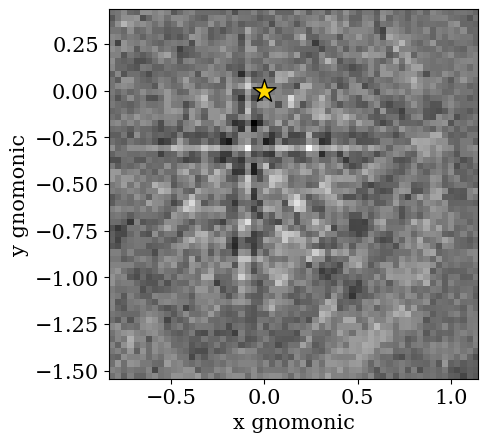

In [10]:
det.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data)

### Generate dictionary

Now we're ready to generate our dictionary of simulated patterns by projecting parts of the master pattern onto our detector for all sampled orientations, using the [get_patterns()](../reference/generated/kikuchipy.signals.EBSDMasterPattern.get_patterns.rst) method.
The method assumes the crystal orientations are represented with respect to the EDAX TSL sample reference frame RD-TD-ND.

<div class="alert alert-info">

Note

It is in general adviced to not compute the dictionary immediately, but let the dictionary indexing method handle this, by passing `compute=False`.
This will return a `LazyEBSD` signal, with the dictionary patterns as a [Dask array](https://docs.dask.org/en/latest/array.html).

**Tip:** If `compute=False`, it is recommended to control the number of patterns in each chunk by passing `chunk_shape=1000` if we want 1 000 patterns per chunk.
Alternatively, `chunk_shape=rot.size // 30` gives 30-31 chunks.
If we at the same time do *not* pass `n_per_iteration` to `dictionary_indexing()`, our here specified chunks size will be the number of simulated patterns matched per iteration, which should give a faster and less memory intensive indexing!
    
</div>

In [11]:
sim = mp.get_patterns(
    rotations=rot,
    detector=det,
    energy=energy,
    dtype_out=np.float32,
    compute=True,
)
sim

[########################################] | 100% Completed | 3.04 ss


<EBSD, title: , dimensions: (30443|60, 60)>

Let's inspect the three first of the simulated patterns

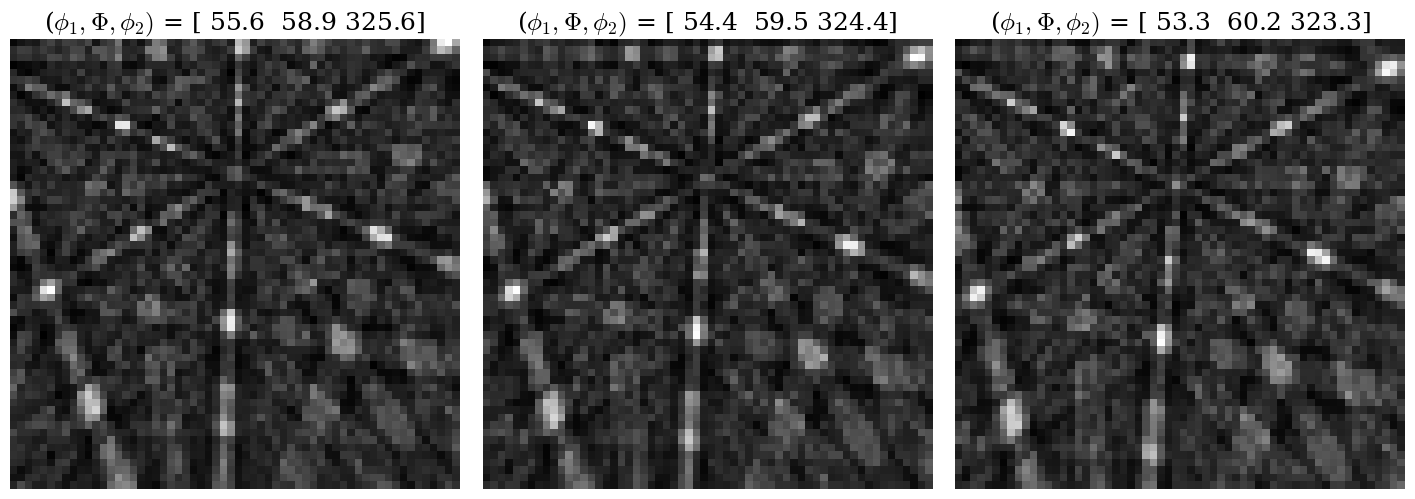

In [12]:
# sim.plot()  # Plot the patterns with a navigator for easy inspection
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i in range(3):
    ax[i].imshow(sim.inav[i].data, cmap="gray")
    euler = np.rad2deg(sim.xmap[i].rotations.to_euler())[0]
    ax[i].set_title(
        f"($\phi_1, \Phi, \phi_2)$ = {np.array_str(euler, precision=1)}"
    )
    ax[i].axis("off")
fig.subplots_adjust(wspace=0.05)

### Perform indexing

*Signal masking was added in version: 0.5.*

The Kikuchi pattern signal is often weak towards the corners of the detector, so we can pass a signal mask to only match the pixels where the mask values are ``False``, i.e. mask out the values that are ``True``.
This convention is in line with how NumPy, Dask, scikit-image etc. defines a mask.
We can pass whatever mask we want, as long as it is a boolean array of the detector shape.

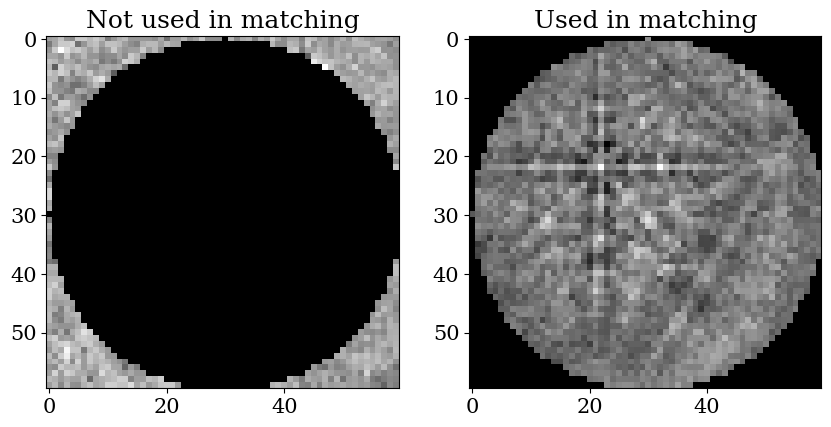

In [13]:
signal_mask = ~kp.filters.Window("circular", det.shape).astype(bool)

p = s.inav[0, 0].data
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(p * signal_mask, cmap="gray")
ax[0].set_title("Not used in matching")
ax[1].imshow(p * ~signal_mask, cmap="gray")
ax[1].set_title("Used in matching");

Finally, let's use the [dictionary_indexing()](../reference/generated/kikuchipy.signals.EBSD.dictionary_indexing.rst) method to match the simulated patterns to our experimental patterns, using the [zero-mean normalized cross correlation (NCC)](../reference/generated/kikuchipy.indexing.NormalizedCrossCorrelationMetric.rst) coefficient $r$ <cite data-cite="gonzalez2017digital">Gonzalez & Woods (2017)</cite>, which is the default similarity metric.
Let's keep the 20 best matching orientations.
A number of 4125 * 30443 comparisons is quite small, which we can do in memory all at once.
However, in cases where the number of comparisons are too big for our memory to handle, we should iterate over the dictionary of simulated patterns by passing the number of patterns per iteration.
To demonstrate this, we do at least 10 iterations here.
The results are returned as a [orix.crystal_map.CrystalMap](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.html).

In [14]:
xmap = s.dictionary_indexing(
    sim,
    metric="ncc",
    keep_n=20,
    n_per_iteration=sim.axes_manager.navigation_size // 10,
    signal_mask=signal_mask,
)
xmap

Dictionary indexing information:
  Phase name: ni
  Matching 4125 experimental pattern(s) to 30443 dictionary pattern(s)
  NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, navigation mask: False, signal mask: True


100%|████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.25it/s]


  Indexing speed: 470.06992 patterns/s, 14310338.62257 comparisons/s


Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

<div class="alert alert-info">

Note

*Added in version: 0.5.*
    
Dictionary indexing of real world data sets takes a long time because the matching is computationally intensive.
The [dictionary_indexing()](../reference/generated/kikuchipy.signals.EBSD.dictionary_indexing.rst) method accepts parameters *n_per_iteration*, *rechunk* and *dtype* that lets us control this behaviour to a certain extent, so be sure to take a look at the method's docstring.

</div>

The [normalized dot product](../reference/generated/kikuchipy.indexing.NormalizedDotProductMetric.rst) can be used instead of the NCC by passing `metric="ndp"`.
A custom metric can be used instead, by creating a class which inherits from the abstract class [SimilarityMetric](../reference/generated/kikuchipy.indexing.SimilarityMetric.rst).

The results can be exported to an HDF5 file re-readable by orix, or an .ang file readable by MTEX and some commercial packages

In [15]:
temp_dir = tempfile.mkdtemp() + "/"
io.save(temp_dir + "ni.h5", xmap)
io.save(temp_dir + "ni.ang", xmap)

### Validate indexing results

With the [orix library](https://orix.readthedocs.io) we can plot inverse pole figures (IPFs), color orientations to produce orientation maps (also called IPF maps), and more.
This is useful to quickly validate our results before processing them further.
If we want to analyze the results in terms of reconstructed grains, textures from orientation density functions, or similar, we have to use other software, like MTEX.

Let's generate an IPF color key and plot it

IPFColorKeyTSL, symmetry: m-3m, direction: [1 0 0]


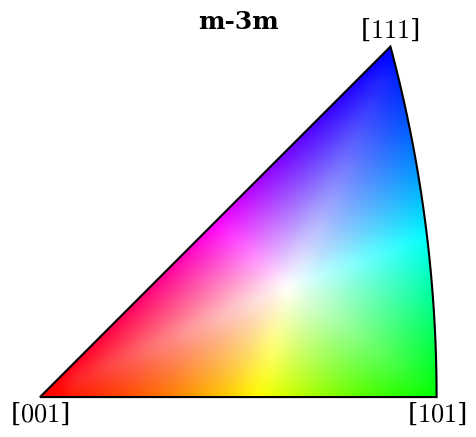

In [16]:
pgm3m = ni.point_group

ckey = plot.IPFColorKeyTSL(pgm3m, direction=Vector3d.xvector())
print(ckey)
ckey.plot()

With this color key we can color orientations according to which crystal directions the sample direction $X$ points in in every map pixel (overlaying the NCC scores of the best match)

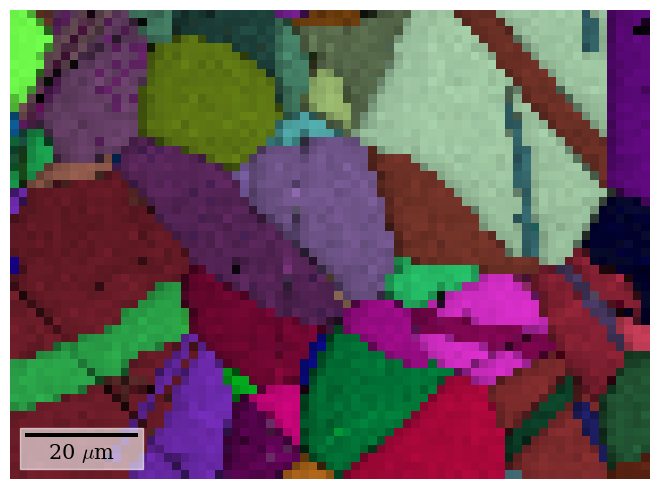

In [17]:
rgb_x = ckey.orientation2color(xmap.orientations)

xmap.plot(rgb_x, overlay=xmap.scores[:, 0], remove_padding=True)

With a few more lines, we can plot maps for all three sample directions

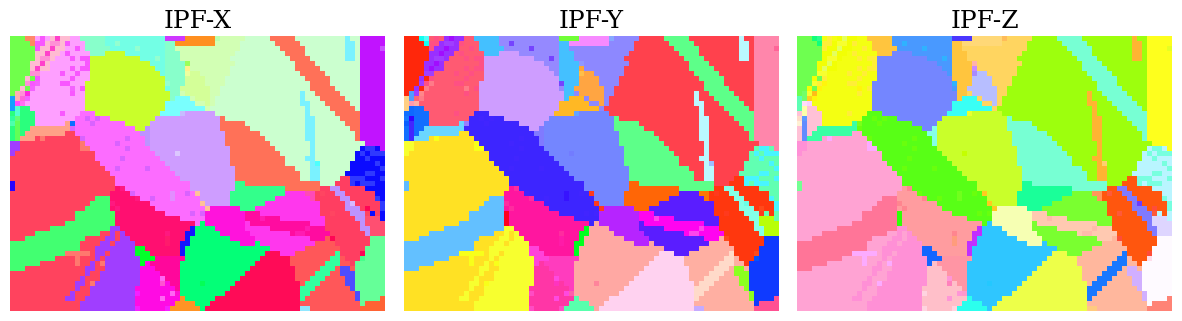

In [18]:
ori = xmap.orientations
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for ax, v, title in zip(axes, directions, ("X", "Y", "Z")):
    ckey.direction = v
    rgb = ckey.orientation2color(ori).reshape(xmap.shape + (3,))
    ax.imshow(rgb)
    ax.axis("off")
    ax.set_title(f"IPF-{title}")
fig.subplots_adjust(wspace=0.05)

The sample is recrystallized Ni, so we expect a continuous color within grains, except for twinning grains.
The orientation maps are mostly in line with our expectation.
Some grains have a scatter of similar colors, which is most likely due to the discrete nature of our dictionary.
To improve upon this result we can reduce the orientation sampling characteristic distance.
This will increase our dictionary size and thus our indexing time.
An alternative is to perform orientation refinement, which we will do below.

We can get further confirmation of our initial analysis by inspecting some indexing quality maps, like the best matching scores and so-called orientation similarity (OS) map, which compares the best matching orientations for each pattern to it's nearest neighbours.
Let's get the NCC map in the correct shape from the CrystalMap’s scores property and the OS map with [orientation_similarity_map()](../reference/generated/kikuchipy.indexing.orientation_similarity_map.rst) using the full list of best matches per point

In [19]:
ncc_map = xmap.scores[:, 0].reshape(*xmap.shape)
os_map = kp.indexing.orientation_similarity_map(xmap)

And plot the maps

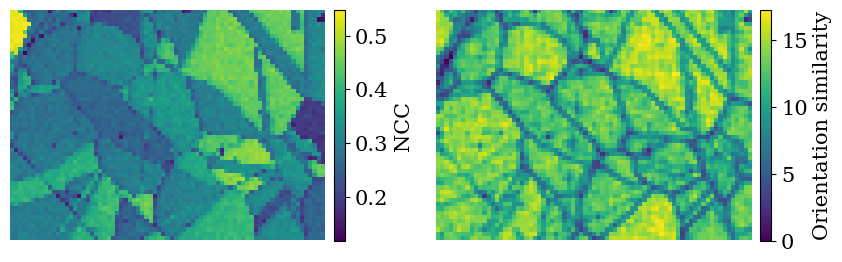

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(11, 3))
im0 = ax[0].imshow(ncc_map)
im1 = ax[1].imshow(os_map)
fig.colorbar(im0, ax=ax[0], label="NCC", pad=0.02)
fig.colorbar(im1, ax=ax[1], label="Orientation similarity", pad=0.02)
for a in ax:
    a.axis("off")
fig.subplots_adjust(wspace=0)

From the NCC map we see that some grains match better than others.
Due to the discrete nature of our dictionary, it is safe to assume that the best matching grains have patterns more similar to those in the dictionary than the others, i.e. the different coefficients does not reflect anything physical in the microstructure.
The OS map doesn't tell us much more than the NCC map in this case.

We can use the crystal map property `simulation_indices` to get the best matching simulated patterns from the dictionary of simulated patterns

In [21]:
best_patterns = sim.data[xmap.simulation_indices[:, 0]].reshape(s.data.shape)
s_best = kp.signals.EBSD(best_patterns)
s_best

<EBSD, title: , dimensions: (75, 55|60, 60)>

The simplest way to visually compare the experimental and best matching simulated patterns is to plot them with the same navigator.
Let's create an RGB navigator signal from the IPF-X orientation map with [get_rgb_navigator()](../reference/generated/kikuchipy.draw.get_rgb_navigator.rst).
When using an interactive backend like `Qt5Agg`, we can then move the red square around to look at the patterns in each point.

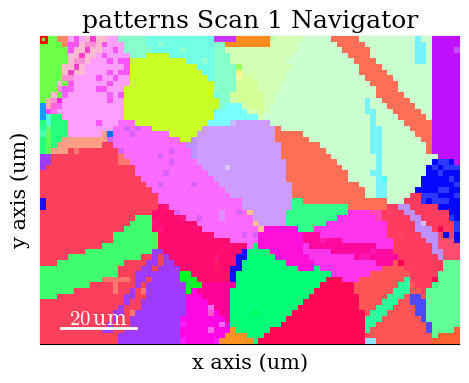

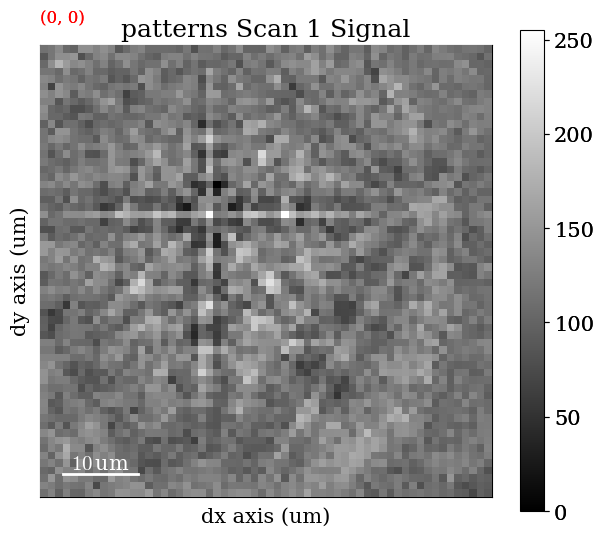

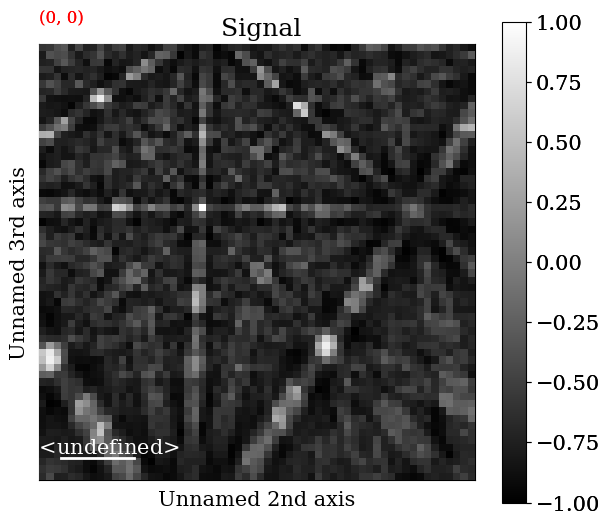

In [22]:
rgb_navigator = kp.draw.get_rgb_navigator(rgb_x.reshape(xmap.shape + (3,)))
hs.plot.plot_signals([s, s_best], navigator=rgb_navigator)

Let's also plot the best matches for patterns from two grains

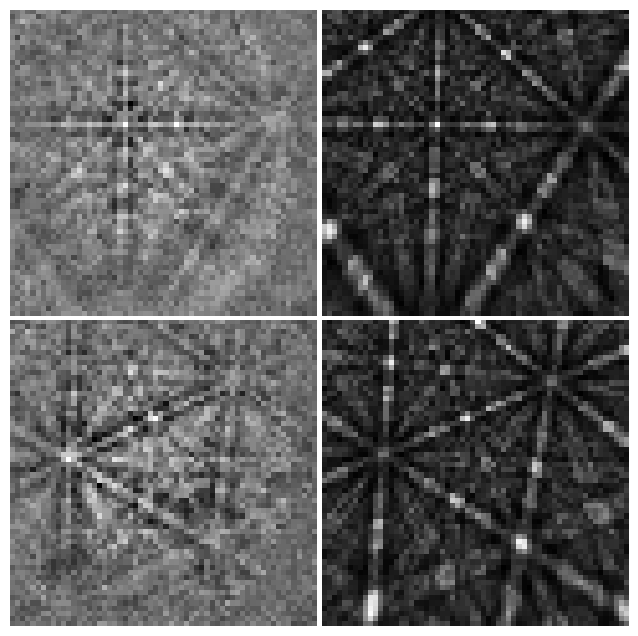

In [23]:
grain1 = (0, 0)
grain2 = (30, 10)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
ax[0, 0].imshow(s.inav[grain1].data, cmap="gray")
ax[0, 1].imshow(s_best.inav[grain1].data, cmap="gray")
ax[1, 0].imshow(s.inav[grain2].data, cmap="gray")
ax[1, 1].imshow(s_best.inav[grain2].data, cmap="gray")
for a in ax.ravel():
    a.axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.01)

## Refinement

Let's look at the effect of three refinement routes, all implemented as `EBSD` methods:

1. Refine orientations while keeping the PCs fixed: [refine_orientation()](../reference/generated/kikuchipy.signals.EBSD.refine_orientation.rst) 
2. Refine PCs while keeping the orientations fixed: [refine_projection_center()](../reference/generated/kikuchipy.signals.EBSD.refine_projection_center.rst) 
3. Refine orientations and PCs at the same time: [refine_orientation_projection_center()](../reference/generated/kikuchipy.signals.EBSD.refine_orientation_projection_center.rst) 

For each route we will compare the maps and histograms of NCC scores before and after refinement, and also the PC parameters if appropriate.

Optimization is performed using an algorithm from the [SciPy library](https://docs.scipy.org/doc/scipy/reference/optimize.html) or the [NLopt library](https://nlopt.readthedocs.io/en/latest/NLopt_Python_Reference/).
Note that NLopt is an optional dependency (see [the installation guide](../user/installation.rst#with-pip) for details).
For every orientation and/or PC, we want to iteratively increase the similarity (NCC score) between our experimental pattern and a new simulated pattern projected onto our EBSD detector for every iteration until the score increase from one iteration to the next is below a certain threshold, by default 0.0001 in most cases.
The orientation and/or PC is changed slightly in a controlled manner by the optimization algorithm for every iteration.
We have access to both local and global optimization algorithms.
Consult the kikuchipy docstring methods and the documentation of SciPy and NLopt, all linked above, for all available parameters and options.

Note that while we here refine orientations obtained from DI, any orientation results, e.g. from Hough indexing, can be refined with this approach, as long as an appropriate master pattern and [EBSDDetector](../reference/generated/kikuchipy.detectors.EBSDDetector.rst) is provided, and the orientation results are passed as a [CrystalMap](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.html).

<div class="alert alert-info">

Note

When using the Nelder-Mead optimization algorithm, EBSD refinement is generally faster with NLopt than with SciPy.
Therefore, it is recommended to use NLopt.
NLopt is however not as available on various machine architectures and across Python versions as SciPy is.
This is why NLopt is an optional dependency and why SciPy's Nelder-Mead algorithm is the default in all refinement methods.

</div>

### Refine orientations

We use [refine_orientation()](../reference/generated/kikuchipy.signals.EBSD.refine_orientation.rst) to refine orientations while keeping the PCs fixed, using the default local Nelder-Mead simplex method from SciPy

In [24]:
xmap_ref = s.refine_orientation(
    xmap=xmap,
    detector=det,
    master_pattern=mp,
    energy=energy,
    signal_mask=signal_mask,
    # The following are default values
    method="minimize",
    method_kwargs=dict(method="Nelder-Mead", tol=1e-4),
    compute=True,
)

Refinement information:
  Method: Nelder-Mead (local) from SciPy
  Trust region (+/-): None
  Keyword arguments passed to method: {'method': 'Nelder-Mead', 'tol': 0.0001}
Refining 4125 orientation(s):
[########################################] | 100% Completed | 59.70 s
Refinement speed: 69.07056 patterns/s


Compare the NCC score maps.
We use the same colorbar bounds for both maps

In [25]:
ncc_after_ori_ref = xmap_ref.get_map_data("scores")

ncc_di_min = np.min(ncc_map)
ncc_di_max = np.max(ncc_map)
ncc_ori_ref_min = np.min(ncc_after_ori_ref)
ncc_ori_ref_max = np.max(ncc_after_ori_ref)

vmin = min([ncc_di_min, ncc_ori_ref_min])
vmax = max([ncc_di_max, ncc_ori_ref_max])

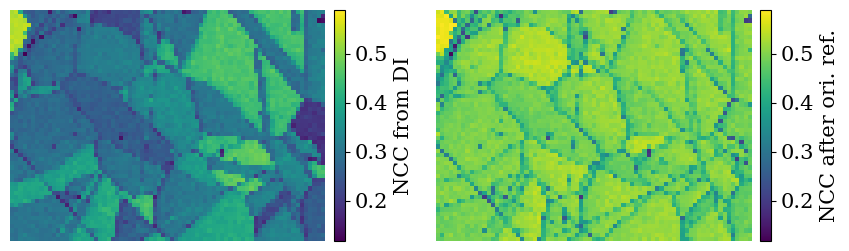

In [26]:
ncc_after_ori_ref_label = "NCC after ori. ref."

fig, ax = plt.subplots(ncols=2, figsize=(11, 3))
im0 = ax[0].imshow(ncc_map, vmin=vmin, vmax=vmax)
im1 = ax[1].imshow(ncc_after_ori_ref, vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax[0], label="NCC from DI", pad=0.02)
fig.colorbar(im1, ax=ax[1], label=ncc_after_ori_ref_label, pad=0.02)
for a in ax:
    a.axis("off")
fig.subplots_adjust(wspace=0)

Compare the histograms

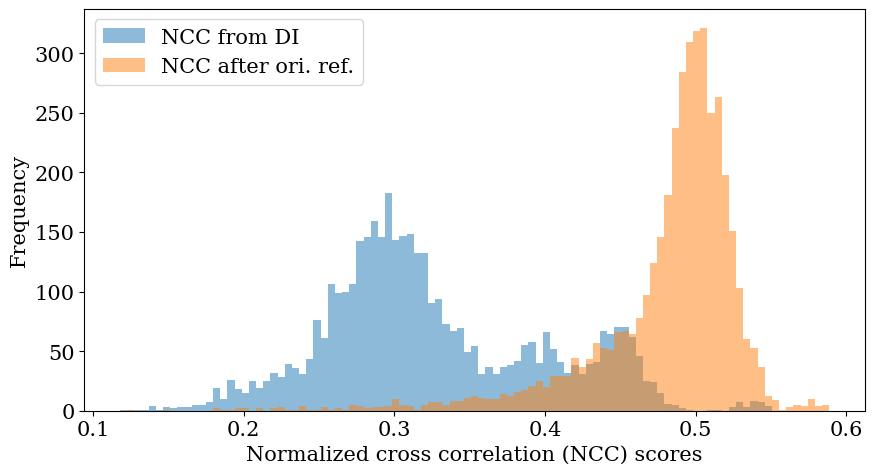

In [27]:
bins = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(ncc_map.ravel(), bins, alpha=0.5, label="NCC from DI")
_ = ax.hist(
    ncc_after_ori_ref.ravel(),
    bins,
    alpha=0.5,
    label=ncc_after_ori_ref_label,
)
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout();

We see that DI found the best orientation (with a fixed PC) for most of the patterns, which the refinement was able to improve further.
However, there are a few patterns with a very low NCC score (0.1-0.2) which refinement couldn't improve upon, which tells us that these were most likely misindexed during DI.
If there are Kikuchi bands in these patterns, a larger dictionary with a finer orientation sampling could improve indexing of them.

Let's also plot the IPF-X orientation maps before and after refinement, and also the disorientation angle (smallest misorientation angle found after accounting for symmetry) difference between the two maps

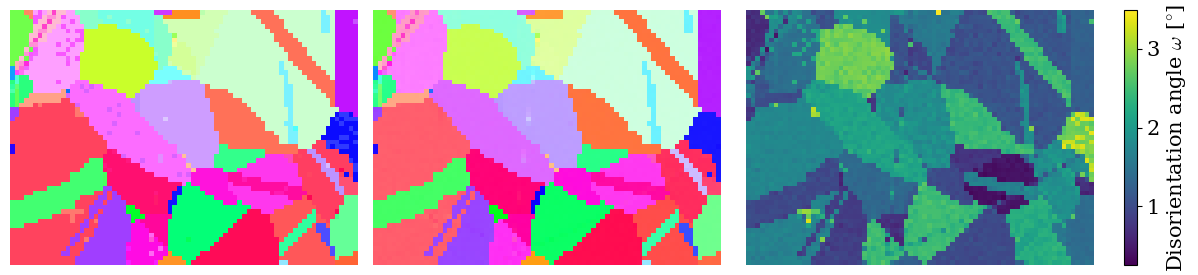

In [28]:
ori_ref = xmap_ref.orientations

ckey.direction = Vector3d.xvector()
rgb_x = ckey.orientation2color(ori)
rgb_x_ref = ckey.orientation2color(ori_ref)

mori_angle = np.rad2deg(ori.angle_with(ori_ref).data)

fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
ax[0].imshow(rgb_x.reshape(xmap.shape + (3,)))
ax[1].imshow(rgb_x_ref.reshape(xmap.shape + (3,)))
im2 = ax[2].imshow(mori_angle.reshape(xmap.shape))
fig.colorbar(
    im2, ax=ax[2], label=r"Disorientation angle $\omega$ [$^{\circ}$]"
)
for a in ax:
    a.axis("off")
fig.tight_layout(w_pad=-12)

We see that refinement was able to remove the scatter of similar colors in the grains.

Finally, let's plot the IPF-X map with correlation scores overlayed.
We will also plot the IPF color key in the bottom right corner.

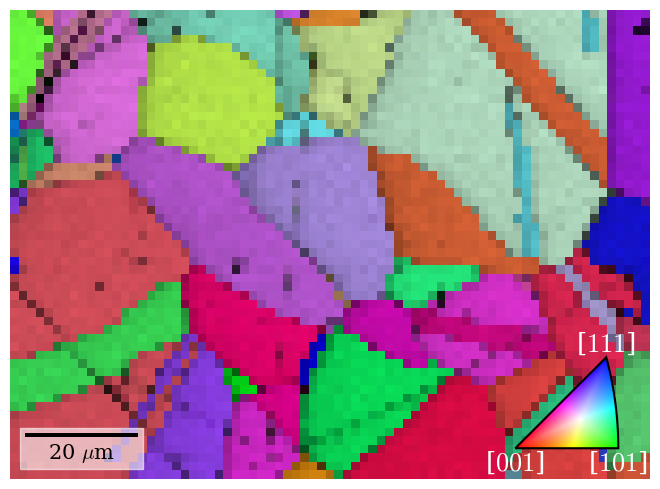

In [29]:
fig = xmap_ref.plot(
    rgb_x_ref, overlay="scores", remove_padding=True, return_figure=True
)

# Place color key in bottom right corner,
# coordinates are [left, bottom, width, height]
ax_ckey = fig.add_axes(
    [0.77, 0.07, 0.2, 0.2], projection="ipf", symmetry=pgm3m
)
ax_ckey.plot_ipf_color_key(show_title=False)
ax_ckey.patch.set_facecolor("None")
_ = [text.set_color("w") for text in ax_ckey.texts]  # White [uvw]

### Refine projection centers

We use [refine_projection_center()](../reference/generated/kikuchipy.signals.EBSD.refine_projection_center.rst) to refine PCs while keeping the orientations fixed.
We'll demonstrate this using the local modified Powell method from SciPy.
This method is also known as Bound Optimization BY Quadratic Approximation (BOBYQA), and is used in EMsoft and discussed by <cite data-cite="singh2017application">Singh et al. (2017)</cite>.
We will pass a `trust_region` of +/- 2% for the PC parameters to use as upper and lower bounds during refinement.

We can also pass `compute=False`, to do the refinement later.
The results will then be a [dask.array.Array](https://docs.dask.org/en/latest/generated/dask.array.Array.html#dask.array.Array).
We can pass this array to [kikuchipy.indexing.compute_refine_projection_center_results()](../reference/generated/kikuchipy.indexing.compute_refine_projection_center_results.rst) and perform the refinement to retrieve the results

In [30]:
result_arr = s.refine_projection_center(
    xmap=xmap,
    detector=det,
    master_pattern=mp,
    energy=energy,
    signal_mask=signal_mask,
    method="minimize",
    method_kwargs=dict(method="Powell", tol=1e-3),
    trust_region=[0.02, 0.02, 0.02],
    compute=False,
)

Refinement information:
  Method: Powell (local) from SciPy
  Trust region (+/-): [0.02 0.02 0.02]
  Keyword arguments passed to method: {'method': 'Powell', 'tol': 0.001}


In [31]:
(
    ncc_after_pc_ref,
    det_ref,
) = kp.indexing.compute_refine_projection_center_results(
    results=result_arr, detector=det, xmap=xmap
)

Refining 4125 projection center(s):
[########################################] | 100% Completed | 59.27 s
Refinement speed: 69.52974 patterns/s


Note that `refine_orientation()` and `refine_orientation_projection_center()` also takes the `compute` parameter, and there are similar functions to compute the refinement results: [kikuchipy.indexing.compute_refine_orientation_results()](../reference/generated/kikuchipy.indexing.compute_refine_orientation_results.rst) and [kikuchipy.indexing.compute_refine_orientation_projection_center_results()](../reference/generated/kikuchipy.indexing.compute_refine_orientation_projection_center_results.rst).

Let's plot the refined scores and PCs

In [32]:
ncc_pc_ref_min = np.min(ncc_after_pc_ref)
ncc_pc_ref_max = np.max(ncc_after_pc_ref)

vmin2 = min([ncc_di_min, ncc_pc_ref_min])
vmax2 = max([ncc_di_max, ncc_pc_ref_max])

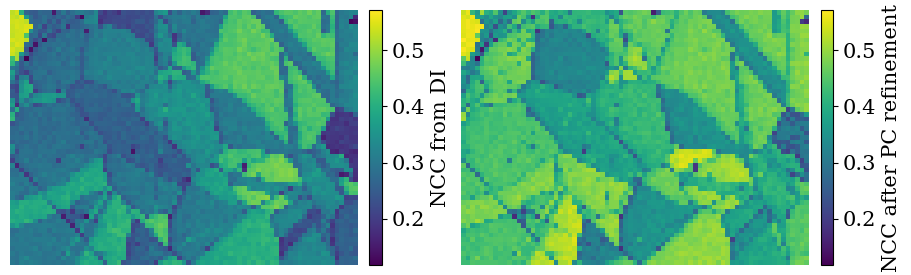

In [33]:
ncc_after_pc_ref_label = "NCC after PC refinement"

fig, ax = plt.subplots(ncols=2, figsize=(11, 3))
im0 = ax[0].imshow(ncc_map, vmin=vmin2, vmax=vmax2)
im1 = ax[1].imshow(ncc_after_pc_ref, vmin=vmin2, vmax=vmax2)
fig.colorbar(im0, ax=ax[0], label="NCC from DI", pad=0.02)
fig.colorbar(im1, ax=ax[1], label=ncc_after_pc_ref_label, pad=0.02)
for a in ax:
    a.axis("off")
fig.tight_layout(w_pad=-7)

Compare the NCC score histograms

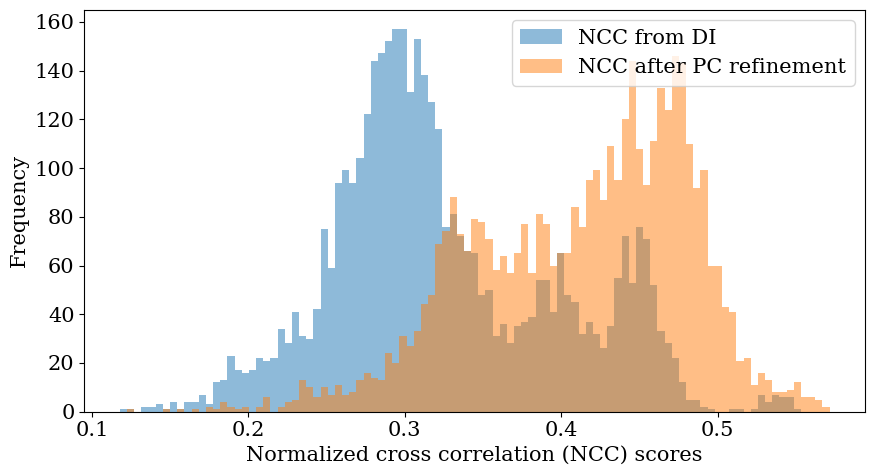

In [34]:
bins = np.linspace(vmin2, vmax2, 100)
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(ncc_map.ravel(), bins, alpha=0.5, label="NCC from DI")
_ = ax.hist(
    ncc_after_pc_ref.ravel(),
    bins,
    alpha=0.5,
    label=ncc_after_pc_ref_label,
)
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout();

PC used in DI:          [0.421  0.2206 0.5049]
PC after PC refinement: [0.4192 0.222  0.5067]


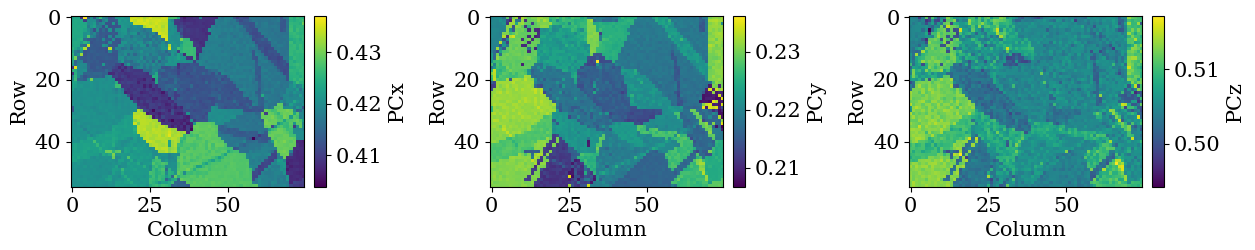

In [35]:
print(
    f"PC used in DI:          {det.pc_average}\n"
    f"PC after PC refinement: {det_ref.pc_average.round(4)}"
)

det_ref.plot_pc()

The maps indicate an orientation dependence of the PC, meaning that changes in PC can be accomodated by crystal rotations, to a certain extent. We can plot the PCs as functions of each other and color them according to the IPF-X map above to see this more clearly

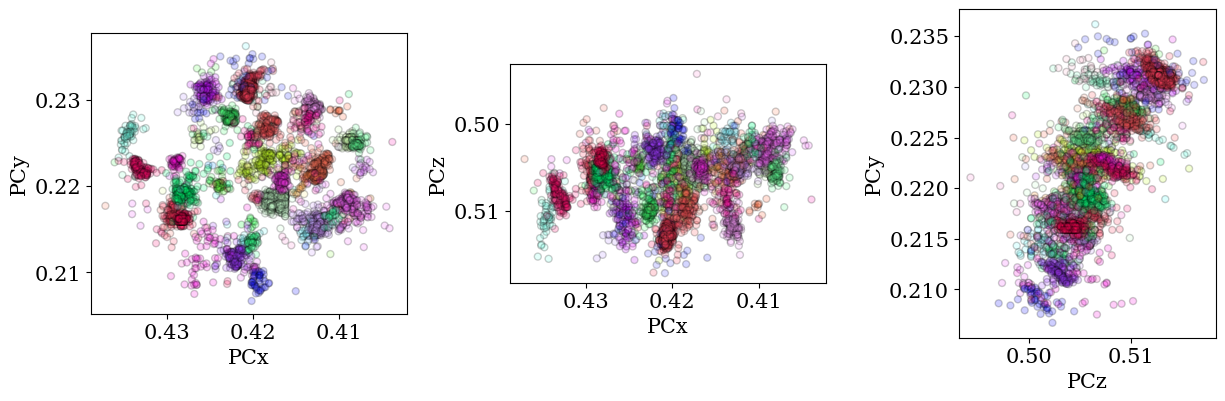

In [36]:
det_ref.plot_pc("scatter", c=rgb_x, alpha=0.2)

This orientation dependent "slop" is nicely demonstrated by <cite data-cite="pang2020global">Pang et al. (2020)</cite>. Parts of their analysis is shown in the [Orientation dependence of the projection center tutorial](pc_orientation_dependence.ipynb).

### Refine orientations and projection centers

We use [refine_orientation_projection_center()](../reference/generated/kikuchipy.signals.EBSD.refine_orientation_projection_center.rst) to refine orientations and PCs at the same time.
To do this we'll use the implementation of Nelder-Mead in NLopt, an optional dependency (see [the installation guide](../user/installation.rst#with-pip) for details).

In [37]:
xmap_ref2, det_ref2 = s.refine_orientation_projection_center(
    xmap=xmap,
    detector=det,
    master_pattern=mp,
    energy=energy,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[2, 2, 2, 0.05, 0.05, 0.05],
    rtol=1e-3,
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [2.   2.   2.   0.05 0.05 0.05]
  Relative tolerance: 0.001
Refining 4125 orientation(s) and projection center(s):
[########################################] | 100% Completed | 74.83 s
Refinement speed: 55.09057 patterns/s


In [38]:
xmap_ref

Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores
Scan unit: um

Compare the NCC score maps. We use the same colorbar bounds for both maps

In [39]:
ncc_after_ori_pc_ref = xmap_ref2.get_map_data("scores")

ncc_ori_pc_ref_min = np.min(ncc_after_ori_pc_ref)
ncc_ori_pc_ref_max = np.max(ncc_after_ori_pc_ref)

vmin3 = min([ncc_di_min, ncc_ori_pc_ref_min])
vmax3 = max([ncc_di_max, ncc_ori_pc_ref_max])

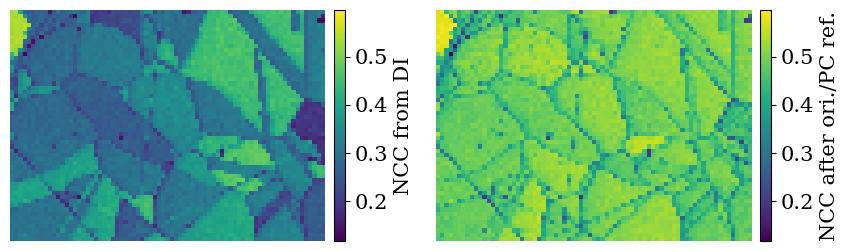

In [40]:
ncc_after_ori_pc_ref_label = "NCC after ori./PC ref."

fig, ax = plt.subplots(ncols=2, figsize=(11, 3))
im0 = ax[0].imshow(ncc_map, vmin=vmin3, vmax=vmax3)
im1 = ax[1].imshow(ncc_after_ori_pc_ref, vmin=vmin3, vmax=vmax3)
fig.colorbar(im0, ax=ax[0], label="NCC from DI", pad=0.02)
fig.colorbar(im1, ax=ax[1], label=ncc_after_ori_pc_ref_label, pad=0.02)
for a in ax:
    a.axis("off")
fig.subplots_adjust(wspace=0)

Compare the histograms

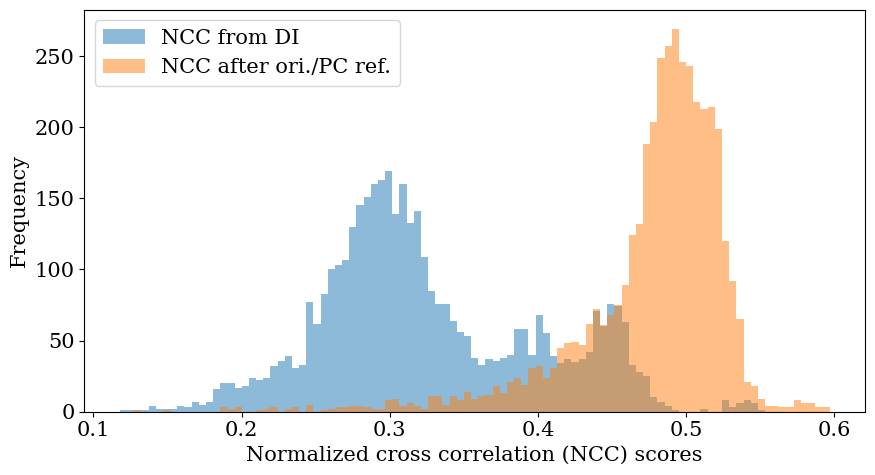

In [41]:
bins = np.linspace(vmin3, vmax3, 100)
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(ncc_map.ravel(), bins, alpha=0.5, label="NCC from DI")
_ = ax.hist(
    ncc_after_ori_pc_ref.ravel(),
    bins,
    alpha=0.5,
    label=ncc_after_ori_pc_ref_label,
)
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout();

Let's also inspect the refined PC parameters

PC used in DI:          [0.421  0.2206 0.5049]
PC after PC refinement: [0.4223 0.219  0.505 ]


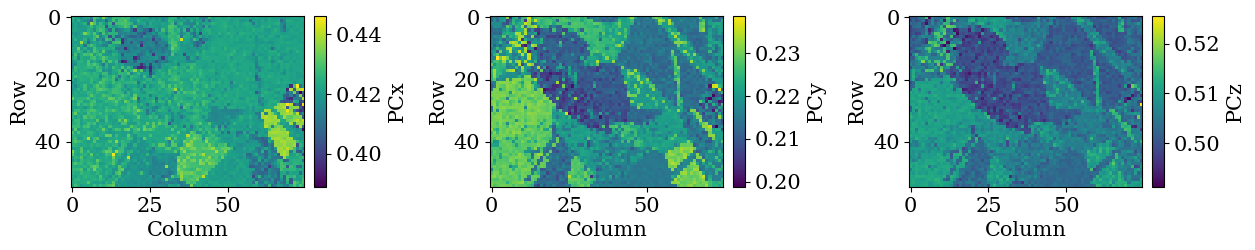

In [42]:
print(
    f"PC used in DI:          {det.pc_average}\n"
    f"PC after PC refinement: {det_ref2.pc_average.round(4)}"
)

det_ref2.plot_pc()

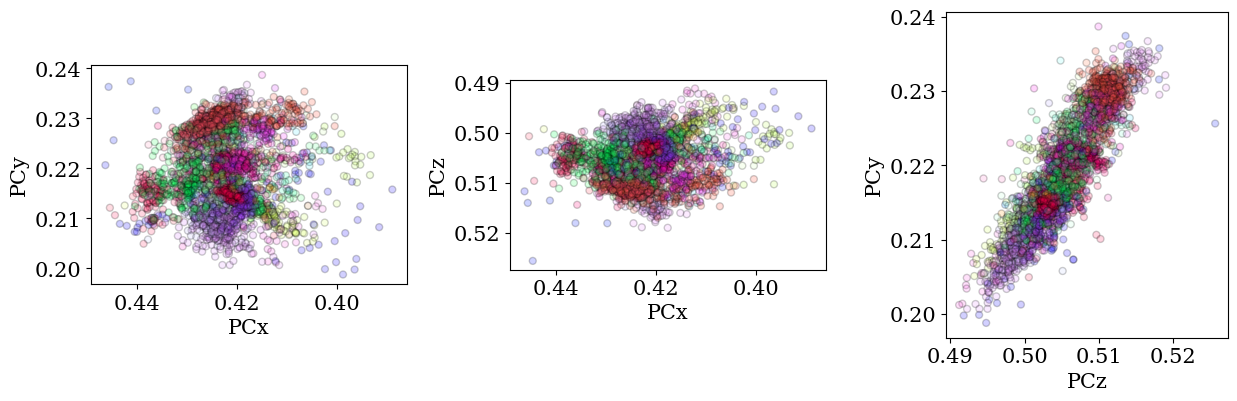

In [43]:
rgbx_ref2 = ckey.orientation2color(xmap_ref2.orientations)
det_ref2.plot_pc("scatter", c=rgbx_ref2, alpha=0.2)

We see that the ranges of refined PCs have narrowed compared to when only the PC was optimized (as seen above). But, the unexpected inverse relation between PCz and PCy remains.

It is generally advisable to refine orientations and PCs simultaneously only when estimating PCs in a grid across the sample in order to fit a plane of PCs to this grid. Indexing can then be performed with a PC from this plane for each pattern, only refining the orientation.

In [44]:
# Remove files written to disk in this tutorial
import os

os.remove(temp_dir + "ni.h5")
os.remove(temp_dir + "ni.ang")
os.rmdir(temp_dir)